In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load and preprocess data
df = pd.read_csv("Historical_data.csv", parse_dates=["Date"], index_col="Date", dtype=str)
df.replace({r"[\$,]": ""}, regex=True, inplace=True)
df = df.astype("float64")
df = df.sort_index(ascending=True)

# Calculate log returns for stability and compounding effects
log_returns = np.log(df / df.shift(1)).dropna()

# Annualize mean returns and covariance matrix
annual_mean = log_returns.mean() * 252
annual_cov = log_returns.cov() * 252


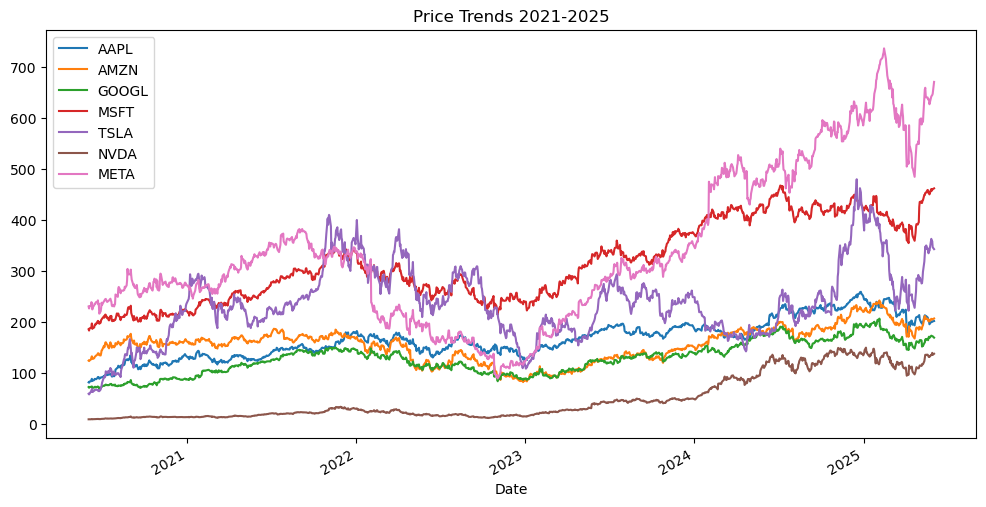

Cumulative Returns over 4 years:
 AAPL      1.481545
AMZN      0.667608
GOOGL     1.348944
MSFT      1.492285
TSLA      4.822120
NVDA     14.664766
META      1.914929
dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-06-03 to 2025-06-02
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1256 non-null   float64
 1   AMZN    1256 non-null   float64
 2   GOOGL   1256 non-null   float64
 3   MSFT    1256 non-null   float64
 4   TSLA    1256 non-null   float64
 5   NVDA    1256 non-null   float64
 6   META    1256 non-null   float64
dtypes: float64(7)
memory usage: 78.5 KB
Data info:
 None
Data head:
              AAPL    AMZN  GOOGL    MSFT   TSLA  NVDA    META
Date                                                         
2020-06-03  81.28  123.92  71.96  185.36  58.86  8.77  230.16
2020-06-04  80.58  123.03  70.72  182.92  57.63  8.77  226.29
2020-06-05  82.88  124.15  72.00  187.20  5

In [41]:
# Check price trends visually
import matplotlib.pyplot as plt

df.plot(figsize=(12, 6), title='Price Trends 2021-2025')
plt.show()

# Check cumulative returns
cumulative_returns = (df.iloc[-1] / df.iloc[0]) - 1
print("Cumulative Returns over 4 years:\n", cumulative_returns)

# Verify data completeness and no missing dates
print("Data info:\n", df.info())
print("Data head:\n", df.head())
print("Data tail:\n", df.tail())


In [42]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)


In [43]:
from scipy.optimize import minimize

def minimize_volatility(weights, cov_matrix):
    return portfolio_volatility(weights, cov_matrix)

n_assets = len(annual_mean)
bounds = tuple((0, 1) for _ in range(n_assets))  # Long-only constraint
initial_weights = np.repeat(1/n_assets, n_assets)

target_returns = np.linspace(annual_mean.min(), annual_mean.max(), 100)
efficient_volatility = []

for target_return in target_returns:
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, annual_mean) - target_return}
    )
    
    result = minimize(
        minimize_volatility,
        initial_weights,
        args=(annual_cov,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    if result.success:
        efficient_volatility.append(result.fun)
    else:
        efficient_volatility.append(np.nan)


In [44]:
print("Annual Mean Returns:\n", annual_mean)
print("Annual Mean Return Summary:")
print(f"Min: {annual_mean.min()}, Max: {annual_mean.max()}, Mean: {annual_mean.mean()}")

print("Annual Covariance Matrix Eigenvalues:")
print(np.linalg.eigvals(annual_cov))

Annual Mean Returns:
 AAPL     0.182501
AMZN     0.102686
GOOGL    0.171474
MSFT     0.183368
TSLA     0.353737
NVDA     0.552475
META     0.214822
dtype: float64
Annual Mean Return Summary:
Min: 0.10268555131631968, Max: 0.552475162235231, Mean: 0.25158009278664917
Annual Covariance Matrix Eigenvalues:
[0.76900444 0.22241364 0.11633788 0.0643685  0.02089857 0.04181441
 0.03700956]


In [45]:
def minimize_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(len(annual_mean)))
init_guess = np.repeat(1 / len(annual_mean), len(annual_mean))

result = minimize(
    minimize_volatility,
    init_guess,
    args=(annual_cov,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

min_var_weights = result.x
min_var_volatility = np.sqrt(min_var_weights.T @ annual_cov @ min_var_weights)

print("Minimum Variance Portfolio Weights:", min_var_weights)
print("Portfolio Volatility:", min_var_volatility)
print("Minimum Variance Portfolio Expected Return:", portfolio_return(min_var_weights, annual_mean))
print("Minimum Variance Portfolio Sharpe Ratio:", (portfolio_return(min_var_weights, annual_mean) - risk_free_rate) / min_var_volatility)

Minimum Variance Portfolio Weights: [2.96913695e-01 2.19008839e-17 1.97694242e-01 5.05392062e-01
 2.56413814e-17 4.36933476e-17 1.88651178e-17]
Portfolio Volatility: 0.2550270659678792
Minimum Variance Portfolio Expected Return: 0.18075880577266046
Minimum Variance Portfolio Sharpe Ratio: 0.5911482579329388


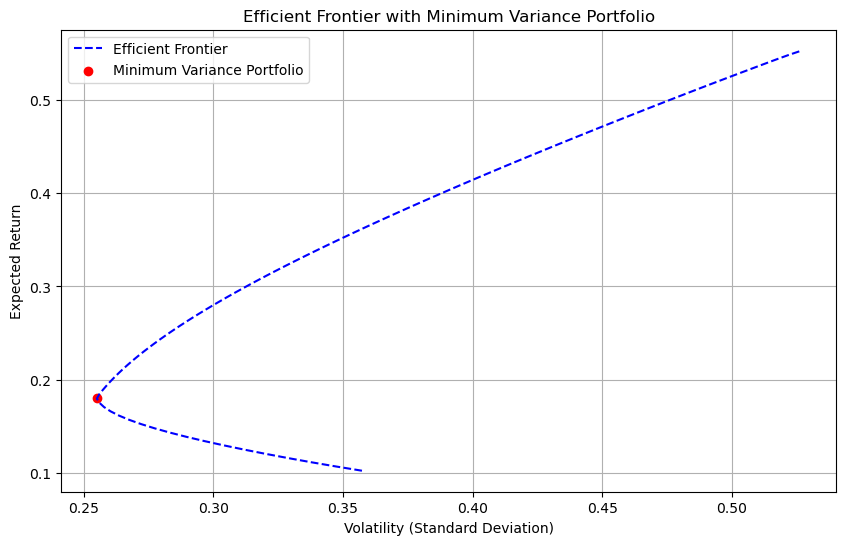

In [46]:
# plotting the minimum variance portfolio on the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(efficient_volatility, target_returns, 'b--', label='Efficient Frontier')
plt.scatter(min_var_volatility, portfolio_return(min_var_weights, annual_mean), color='red', label='Minimum Variance Portfolio')
plt.title('Efficient Frontier with Minimum Variance Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid()
plt.show()